# Overview

**Workflow:**

1. Load the data
2. Clean it:
    * get rid of missing values
    * engineer necessary features
3. Explore
3. Analyze

**Data description:**

Outpatient prescription drugs paid for by state medicaid agencies. Each entry represents an organization that filed a drug reimbursement claim.

**Notes:**

Some stats (appx):

* U.S. population: 325 million.
* 73 million people are on medicaid, that's just over 1/5th of the population.
* 40 million are on medicare.
* 8% of people are not insured.
* 37.7% are on government healthcare, 67% are on private health coverage.
* Out of private, employer based accounts for 56%.

Medicaid is a rather small sample of the population, it would be interesting to see a larger subset.

Demographics of people on Medicaid:

- Medicaid and CHIP participants are among the most vulnerable members of the U.S. population.

![alt text](medicaidstatistics.png)

**Sources**

- https://www.census.gov/library/publications/2018/demo/p60-264.html
- https://data.medicaid.gov/State-Drug-Utilization/State-Drug-Utilization-Data-2017/3v5r-x5x9
- https://www.prb.org/majority-of-people-covered-by-medicaid-and-similar-programs/
- https://www.verywellhealth.com/the-30-most-prescribed-drugs-in-pediatrics-2633435

# Load drug data with selected columns and good memory usage

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

In [52]:
# Check available features

df2007 = pd.read_csv('State_Drug_Utilization_Data_2007.csv', low_memory=False)

In [53]:
len(df2007.columns)

20

In [5]:
# Load state drug data for 2007 - 2017 with appropriate columns

columns = ['State', 'Year', 'Product Name', 'Quarter', 'Number of Prescriptions']
filenames = ['State_Drug_Utilization_Data_' + str(i) + '.csv' for i in range(2007, 2018)]

df = pd.concat(pd.read_csv(filename, usecols=columns) 
               for filename in filenames)

In [445]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37149245 entries, 0 to 4725196
Data columns (total 5 columns):
State                      object
Year                       int64
Quarter                    int64
Product Name               object
Number of Prescriptions    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.7+ GB


In [5]:
df.sample(5)

,State,Year,Quarter,Product Name,Number of Prescriptions
1658516,VT,2009,3,IBUPROFEN,NaN
2444674,NM,2013,3,PACLITAXEL,34.0
1676090,MO,2012,1,VANCOMYCIN,NaN
577432,FL,2012,1,CEPHALEXIN,53.0
3390133,HI,2016,3,OMNIPAQUE,NaN


In [8]:
df.describe(include='all')

,State,Year,Quarter,Product Name,Number of Prescriptions
count,39527716,3.952772e+07,39527716.0,39520556,19480099.0
unique,52,NaN,4.0,33927,67594.0
top,XX,NaN,4.0,LISINOPRIL,15.0
freq,2371072,NaN,10068762.0,464392,360957.0
mean,NaN,2.012807e+03,NaN,NaN,NaN
std,NaN,2.995609e+00,NaN,NaN,NaN
min,NaN,2.007000e+03,NaN,NaN,NaN
25%,NaN,2.011000e+03,NaN,NaN,NaN
50%,NaN,2.013000e+03,NaN,NaN,NaN
75%,NaN,2.015000e+03,NaN,NaN,NaN


# Take care of the missing values in Product Name

In [6]:
# We have 3311 ?'s and 5854 NaNs

print((df['Product Name'] == '?').sum())
print(df.isna().sum())

# Replace ? with nan

df = df.replace('?', np.NaN)

3404
State                             0
Year                              0
Quarter                           0
Product Name                   7160
Number of Prescriptions    20047617
dtype: int64


In [870]:
df.isna().sum()

State                             0
Year                              0
Quarter                           0
Product Name                  10564
Number of Prescriptions    20047617
dtype: int64

In [7]:
# Just drop the nans, there aren't very many of them

df = df.dropna(subset=['Product Name'])
df.isna().sum()

State                             0
Year                              0
Quarter                           0
Product Name                      0
Number of Prescriptions    20038088
dtype: int64

In [8]:
# XX are aggregated entries, remove them

df = df[df.State != 'XX']

In [58]:
# Nullify and impute SD Precriptions in 2007

df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions'] = np.nan

# Randomly sample values from comparable North Dakota
# to fill Nans in South Dakota 2007

samp = df.loc[(df['Year'] <= 2008) & (df['State'] == 'ND'), 'Number of Prescriptions'].sample(7891)
df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions'] = samp.values
# df.loc[(df['Year'] == 2007) & (df['State'] == 'SD')].sample(10)


# What drugs are people on?

In this section, we will see the types of drugs people are taking in the U.S. by state, year, and time of year.

In [60]:
# Factorize into numbers for non-numeric correlations

df.apply(lambda x: x.factorize()[0]).corr()

,State,Year,Quarter,Product Name,Number of Prescriptions
State,1.000000,-0.000949,0.001862,-0.014121,-0.048188
Year,-0.000949,1.000000,0.000441,0.222615,0.015866
Quarter,0.001862,0.000441,1.000000,0.000343,-0.003102
Product Name,-0.014121,0.222615,0.000343,1.000000,-0.045349
Number of Prescriptions,-0.048188,0.015866,-0.003102,-0.045349,1.000000


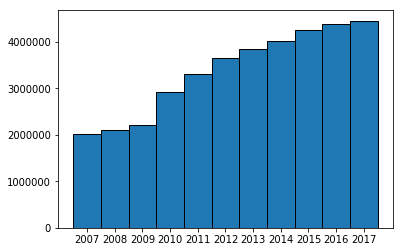

In [72]:
# Plot number of entries for each year

ig, ax = plt.subplots(1,1)
bins = np.arange(2007,2019)
ax.hist(df['Year'], bins=bins, align='left', ec='black')
ax.set_xticks(range(2007,2018));

In [62]:
# 4652 Entries for alprazolam
# this tell us that 4652 organizations in CA prescribed alprazolam from 2007 - 2017

(df[df['Product Name'] == 'ALPRAZOLAM']['State'] == 'CA').value_counts()

False    115657
True       4652
Name: State, dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17720842 entries, 0 to 4725196
Data columns (total 5 columns):
State                      object
Year                       int64
Quarter                    int64
Product Name               object
Number of Prescriptions    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 811.2+ MB


In [66]:
# # Let's see the number of prescriptions by state

# df_p = df[df['Number of Prescriptions'].notnull()]
# df_p['Number of Prescriptions'] = df_p['Number of Prescriptions'].astype('int')

# # NaN all 2007 values

# df_p.loc[(df_p['Year'] == 2007) & (df_p['State'] == 'SD'), 'Number of Prescriptions'] = np.nan

# # Randomly sample values from comparable North Dakota
# # to fill Nans in South Dakota 2007

# samp = df_p.loc[(df_p['Year'] <= 2008) & (df_p['State'] == 'ND'), 'Number of Prescriptions'].sample(7891)
# df_p.loc[(df_p['Year'] == 2007) & (df_p['State'] == 'SD'), 'Number of Prescriptions'] = samp.values

In [855]:
# Sum prescriptions for each state

# df_s = df_p.sample(100)

pv = df_p.pivot_table(values='Number of Prescriptions', index='State', columns='Year', aggfunc=np.sum)
pv['Totals'] = pv.sum(axis=1)
pv

Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Totals
State,,,,,,,,,,,,
MI,6015284.0,5939927.0,6597209.0,15789141.0,20207401.0,20034040.0,20339080.0,23824796.0,27449929.0,31249189.0,31437566.0,208883562.0
VA,3911205.0,4035983.0,4451442.0,5245006.0,10287523.0,10812711.0,11207378.0,10938647.0,10699848.0,11069048.0,10584494.0,93243285.0
CA,33242540.0,32709973.0,33876679.0,47484957.0,54922238.0,52184950.0,55189359.0,69622307.0,92910248.0,99175952.0,102320837.0,673640040.0
GA,6218345.0,6748069.0,7251874.0,11351149.0,13736188.0,16322713.0,16445996.0,16691847.0,16905060.0,16712454.0,17166415.0,145550110.0
KY,9569844.0,9701283.0,10413442.0,12321084.0,13299885.0,12884643.0,12039690.0,14814713.0,17473144.0,18368160.0,17813323.0,148699211.0
NJ,4956174.0,5465737.0,5495048.0,9127501.0,10583525.0,13577737.0,12347236.0,15643611.0,19416630.0,23331897.0,20317549.0,140262645.0
NC,13040271.0,14351953.0,15597138.0,16107806.0,16198633.0,16371258.0,15971071.0,16781514.0,16863580.0,16969943.0,16830684.0,175083851.0
OR,1705752.0,1652967.0,1806479.0,3917179.0,6069443.0,5349193.0,6132972.0,8445760.0,10048537.0,9942009.0,10554852.0,65625143.0
IN,5038073.0,4988902.0,5248996.0,12085864.0,11607717.0,12571502.0,11882283.0,11769464.0,13406037.0,17207302.0,16574743.0,122380883.0


In [857]:
# Discovering new things: no data for Arizona for 2007, 2008, 2009
# but why?

# starts with 2010...checked the actual csv, it's missing!
# they started recording the data in 2010

# Let's infer the values based on comparable states for those years
# AZ population is closest to massachussets so well fill in values from massachussets

values = {2007: 7607295.0, 2008: 7884396.0, 2009: 7719774.0}
pv = pv.fillna(value=values)

# Add totals column

pv['Totals'] = pv.sum(axis=1)

# Check that MA and AZ totals are close

print(pv[pv.index == 'MA']['Totals'])
print(pv[pv.index == 'AZ']['Totals'])

State
MA    398240811.0
Name: Totals, dtype: float64
State
AZ    392516751.0
Name: Totals, dtype: float64


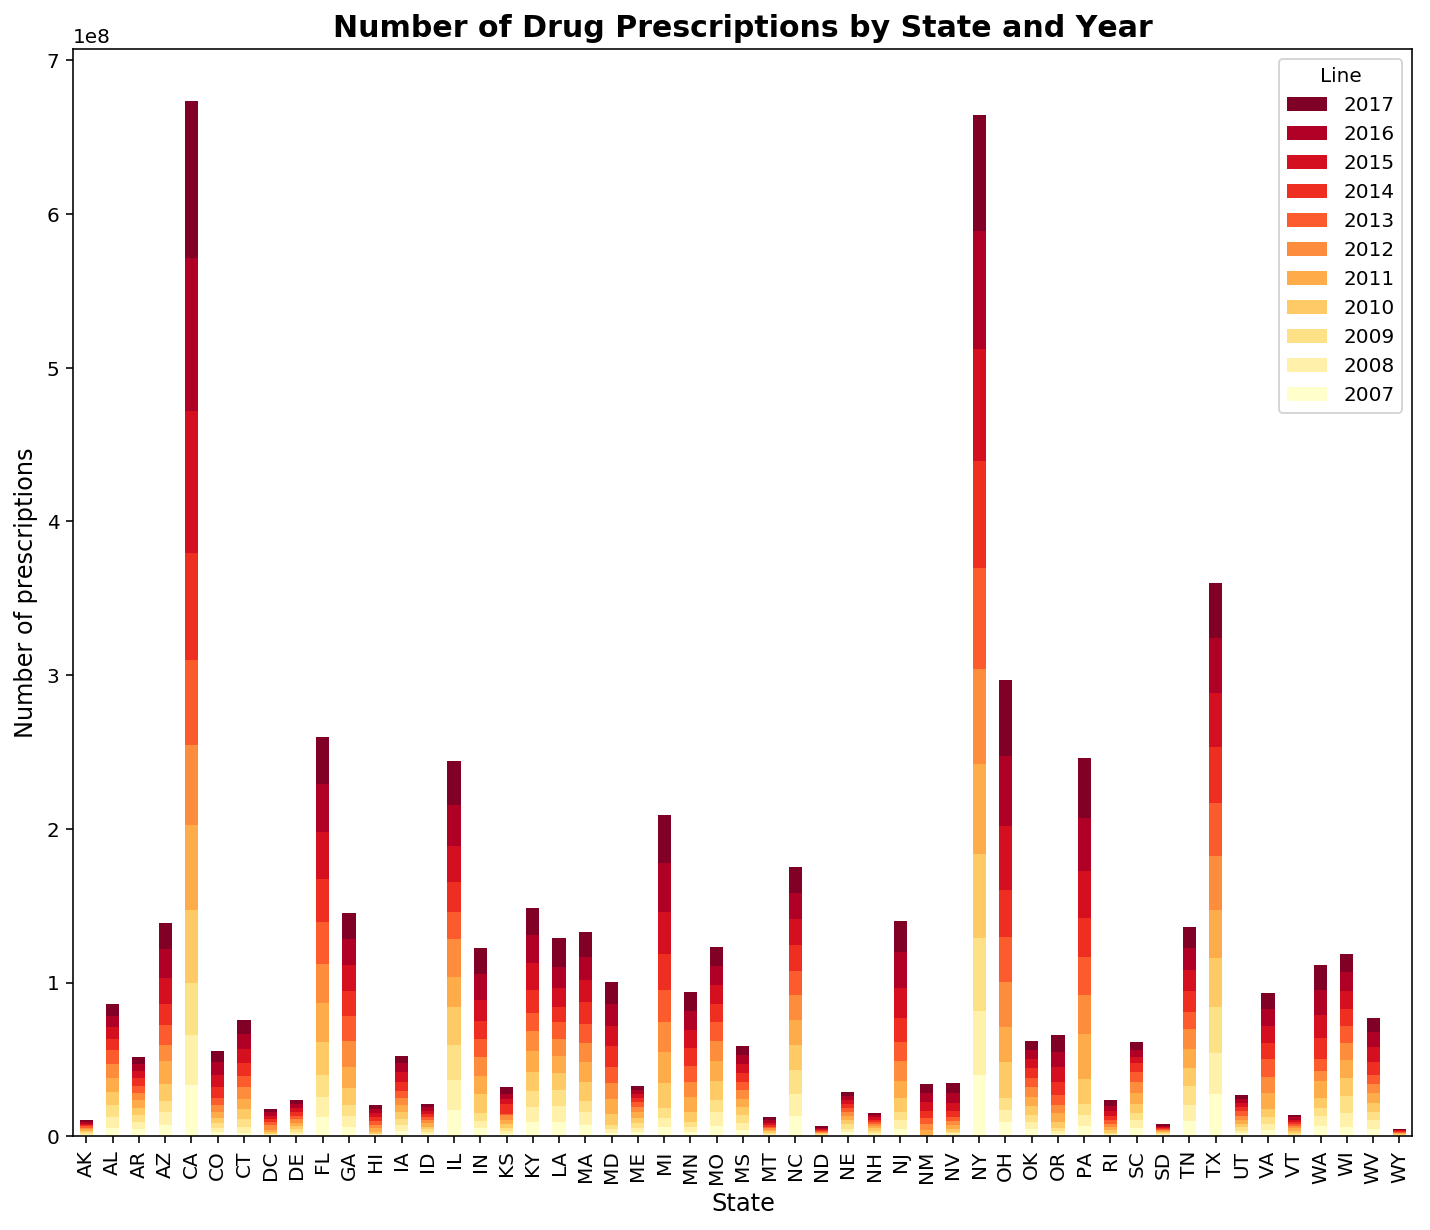

In [858]:
# Number of prescriptions by state 2007 - 2017

ax = pv.iloc[:,:-1].sort_values('State').plot.bar(stacked=True, figsize=(12,10), cmap="YlOrRd")
ax.set_title('Number of Drug Prescriptions by State and Year', size=15, weight='bold')
plt.ylabel('Number of prescriptions', size=12)
plt.xlabel('State', size=12)

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper right');

# Goal for 2/5/2019: drop values for number of prescriptions SD 2007
# and impute them
Note: went back to previous section to do this

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


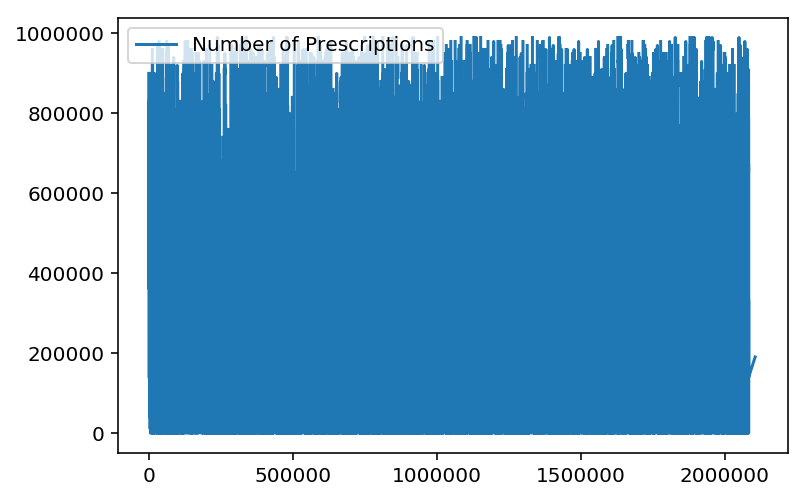

In [630]:
# Plot the outliers
# Compare distribution of 2007 to other years

dfy = df[(df['Year'] == 2007) & (df['State'] == 'SD')]
dfy['Number of Prescriptions'] = dfy['Number of Prescriptions'].dropna().astype('int')
dfP = dfy[['Number of Prescriptions']]
dfP.plot();

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


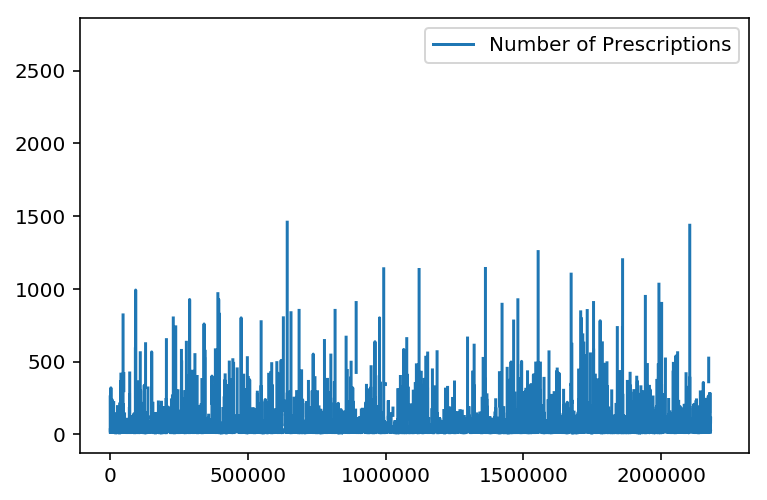

In [627]:
# 2008

df07 = df[(df['Year'] == 2008) & (df['State'] == 'SD')]
df07['Number of Prescriptions'] = df07['Number of Prescriptions'].dropna().astype('int')
dfP = df07[['Number of Prescriptions']]
dfP.plot()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


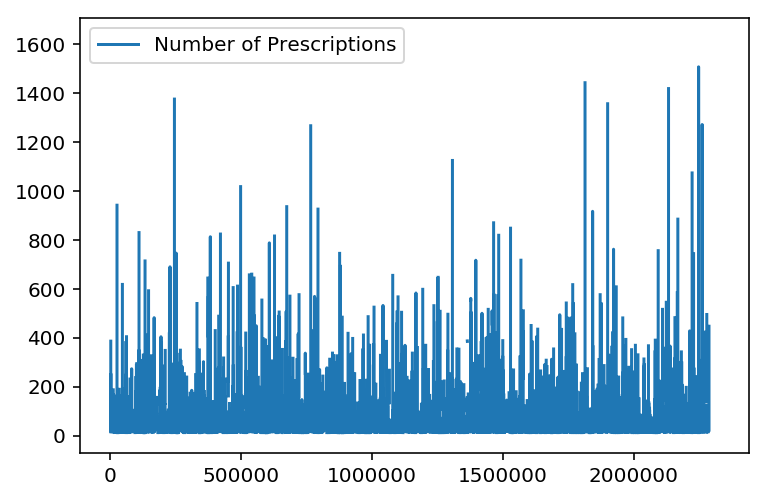

In [628]:
# 2009

df07 = df[(df['Year'] == 2009) & (df['State'] == 'SD')]
df07['Number of Prescriptions'] = df07['Number of Prescriptions'].dropna().astype('int')
dfP = df07[['Number of Prescriptions']]
dfP.plot()

In [721]:
# We see that the distribution for 2007 is very different
# lets drop the values and impute them from previous years

# Comparable is North Dakota

In [813]:
# Imputed SD from ND by random sampling

df_p.loc[(df_p['Year'] == 2007) & (df_p['State'] == 'SD'),:].describe()

,Year,Number of Prescriptions
count,7891.0,7891.000000
mean,2007.0,60.427956
std,0.0,80.806089
min,2007.0,11.000000
25%,2007.0,20.000000
50%,2007.0,33.000000
75%,2007.0,66.000000
max,2007.0,1050.000000


In [796]:
df_p.loc[(df_p['Year'] == 2007) & (df_p['State'] == 'ND'),:].describe()

,Year,Number of Prescriptions
count,6627.0,6627.000000
mean,2007.0,61.229516
std,0.0,81.380051
min,2007.0,11.000000
25%,2007.0,20.000000
50%,2007.0,33.000000
75%,2007.0,66.000000
max,2007.0,1050.000000


# Goal for 2/6/2019: interactive visualization
Interactive visualization that shows the most popular drugs 

In [13]:
# Drop Nans in Number of Prescriptions

df['Number of Prescriptions'] = df.dropna()

In [108]:
# Get the top 100 most prescribed drugs in the nation
# 109 because we drop some of the ones with missing entries

top100 = df.groupby('Product Name')['Number of Prescriptions'].agg('sum').sort_values(ascending=False).head(110)

# get names of drugs into a variable

t100 = top100.index.values

# Make dataframe of top 100 drugs with Drug Name, State, Number of Prescriptions, and Year

df100 = pd.concat(df.loc[df['Product Name'] == drug] for drug in t100)
df100 = df100.sort_values('State')

# See if it worked 

len(df100['Product Name'].unique())

110

In [109]:
# Make abbreviated state into full state name

abb = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'Washington DC': 'DC',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

abb = {state: abbrev for abbrev, state in abb.items()}
df100['State'] = df100['State'].map(abb)

In [110]:
# df100[(df100['Full_ST'] == 'New York') & (df100['Product Name'] == 'LORATADINE')]

df100['Total Number of Prescriptions'] = df100.groupby(['Product Name', 'State'])['Number of Prescriptions'].transform(sum)
# df100.drop(df100.columns[len(df100.columns)-1], axis=1, inplace=True)
# df100 = df100.drop('Total Number of Prescriptions', 1)
# df100 = df100.drop('State', 1)
# df100.rename(columns={'Full_ST':'State'}, inplace=True)
# d = ['ADVAIR DIS', 'Ibuprofen', 'ABILIFY', 'ASPIRIN LO', 'OXYCODONE-', 'VITAMIN D2']

In [111]:
# Drop these drugs for a better heatmap

drop_these_drugs = ["CHILDREN'S", 'ADVAIR DIS', 'Ibuprofen', 
                    'ABILIFY', 'ASPIRIN LO', 'OXYCODONE-', 
                    'VITAMIN D2', 'NAPROXEN 5', 'ASPIRIN EC',
                    'DOCUSATE S']

for i in drop_these_drugs:
    df100.drop(df100.loc[df100['Product Name'] == i].index, inplace=True)
# df100.drop(df100.loc[df100['Product Name'] == 'DOCUSATE S'].index, inplace=True)

In [82]:
# imports for visualization

import hvplot.pandas
import holoviews as hv

In [135]:
# Heatmap by state and year

heatmap = df100.hvplot.heatmap('Product Name', 'State', 'Total Number of Prescriptions',
          height=500, width=1000, xaxis=None, hover_cols=['Year'], 
          title='Top 100 Most Prescribed Drugs in the Nation in 2007 - 2017', cmap='fire')

In [136]:
heatmap

:HeatMap   [Product Name,State]   (Total Number of Prescriptions,Year)

In [118]:
df100.hvplot.heatmap?

In [561]:
# In an ideal situation, I would aggregate all the drugs
# which have a similar name into one

# Something like....if drug contains atleastpartofdrug name:
#     add it to onedrug

In [137]:
len(df100['Product Name'].unique())

100

In [284]:
# heatmap of the top 100 most popular drugs

In [368]:
# Let's try for some more meaningful visualizations

p_agg = df.groupby(['Year', 'Full_ST'])['Number of Prescriptions'].sum()
by_state = p_agg.hvplot('Year', groupby='Full_ST', width=500, dynamic=False)

by_state

:HoloMap   [Full_ST]
   :Curve   [Year]   (Number of Prescriptions)

In [315]:
p_agg.unstack()

State,AK,AL,AR,CA,CO,CT,DC,DE,FL,GA,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,AZ
Year,,,,,,,,,,,,,,,,,,,,,
2007,866966.0,5063769.0,4387245.0,33242540.0,2675967.0,2034521.0,600700.0,1349139.0,12656891.0,6218345.0,...,9972192.0,27409397.0,1863998.0,3911205.0,330070.0,6459647.0,5984722.0,5004804.0,328735.0,NaN
2008,893081.0,7165408.0,4573140.0,32709973.0,2709140.0,4186108.0,581981.0,1524691.0,13103804.0,6748069.0,...,10635137.0,26810699.0,1849329.0,4035983.0,599931.0,6605349.0,9129342.0,5259064.0,175367.0,NaN
2009,912360.0,8083476.0,4823753.0,33876679.0,3034238.0,4990685.0,557815.0,1725211.0,14020503.0,7251874.0,...,11750658.0,29713820.0,2110862.0,4451442.0,1265353.0,5246192.0,11008299.0,5686399.0,445134.0,NaN
2010,986954.0,8477384.0,4775384.0,47484957.0,3493343.0,6191726.0,895121.0,1933403.0,21413018.0,11351149.0,...,12019821.0,31826309.0,2338517.0,5245006.0,1444731.0,6495719.0,11767301.0,5959001.0,471015.0,10446427.0
2011,995382.0,9098135.0,4786969.0,54922238.0,3959590.0,6946822.0,1601569.0,2154930.0,25651500.0,13736188.0,...,12417302.0,31423884.0,2641202.0,10287523.0,1410022.0,10843561.0,11634222.0,6051968.0,481667.0,15043067.0
2012,928916.0,9269301.0,4796924.0,52184950.0,4231767.0,7492878.0,2745875.0,2311384.0,25511904.0,16322713.0,...,12848515.0,34885722.0,2518593.0,10812711.0,1390455.0,7090118.0,11341590.0,5902248.0,488921.0,10367262.0
2013,884855.0,8845704.0,4648374.0,55189359.0,4632106.0,7563835.0,2104073.0,2289759.0,26922741.0,16445996.0,...,11335147.0,34711860.0,2886323.0,11207378.0,1271356.0,7821350.0,10643581.0,5844148.0,463179.0,13145186.0
2014,852928.0,7293223.0,5117150.0,69622307.0,7005635.0,8261250.0,2212999.0,2351937.0,28174841.0,16691847.0,...,13616776.0,36272461.0,2825395.0,10938647.0,1310141.0,13219382.0,11210242.0,8631739.0,461656.0,13788655.0
2015,872577.0,7490298.0,4560582.0,92910248.0,8007266.0,9172199.0,2093567.0,2487867.0,30583413.0,16905060.0,...,13326157.0,35424436.0,2748601.0,10699848.0,1594784.0,15268952.0,11867132.0,9401121.0,465142.0,16896796.0


# Goal for 2/7/2019: blog post and portfolio site

# Goal for 2/8/2019: portfolio site